In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/steam-processed-5-new/steam_subset_5_processed_new.csv
/kaggle/input/steam-20-processed-version/steam_reviews_subset_20_processed_4_25.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import re

# import spacy
# spacy.prefer_gpu()
# nlp = spacy.load("en_core_web_sm")

# wordcloud 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [3]:
# cleaned and processed 20% data sample taken from steam reviews
# data = pd.read_csv("/kaggle/input/steam-20-processed-version/steam_reviews_subset_20_processed_4_25.csv")

In [4]:
# cleaned and processed 5% data sample taken from steam reviews
data = pd.read_csv("/kaggle/input/steam-processed-5-new/steam_subset_5_processed_new.csv")

In [5]:
data.head()

,app_id,app_name,review_text,review_score,review_votes,review_processed
0,237930,Transistor,I think the main thing that surprised me about...,1,0,think main thing surprise game intigration mus...
1,270450,Robot Roller-Derby Disco Dodgeball,Cute little FPS that takes a little practice t...,1,0,cute little fps take little practice learn cat...
2,49520,Borderlands 2,This game is absolutely the best! Totally wort...,1,0,game absolutely good totally worth get cheap s...
3,211400,Deadlight,"Nope, just a nope. Clunky control, I can't sa...",0,0,nope nope clunky control frustrating play ga...
4,219640,Chivalry: Medieval Warfare,I went into Chiv expecting something amazing. ...,1,0,go chiv expect amazing exactally think go ga...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195564 entries, 0 to 195563
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   app_id            195564 non-null  int64 
 1   app_name          195564 non-null  object
 2   review_text       195564 non-null  object
 3   review_score      195564 non-null  int64 
 4   review_votes      195564 non-null  int64 
 5   review_processed  195452 non-null  object
dtypes: int64(3), object(3)
memory usage: 9.0+ MB


In [7]:
data.isnull().sum()

app_id                0
app_name              0
review_text           0
review_score          0
review_votes          0
review_processed    112
dtype: int64

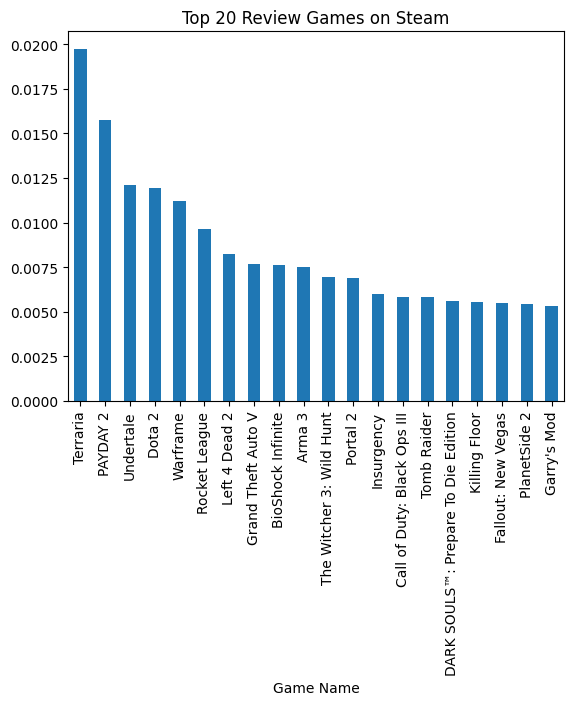

In [8]:
data["app_name"].value_counts(normalize=True, dropna=False).head(20).plot(kind="bar")
plt.xlabel("Game Name")
plt.title("Top 20 Review Games on Steam")
plt.show()

In [9]:
# data[data["review_processed"].isnull()].head()

In [10]:
# remove rows without any data in processed review
data = data[~data["review_processed"].isnull()].copy(deep=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 195452 entries, 0 to 195563
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   app_id            195452 non-null  int64 
 1   app_name          195452 non-null  object
 2   review_text       195452 non-null  object
 3   review_score      195452 non-null  int64 
 4   review_votes      195452 non-null  int64 
 5   review_processed  195452 non-null  object
dtypes: int64(3), object(3)
memory usage: 10.4+ MB


Let's generate some wordclouds to see what users are saying about games they reviewed.

In [12]:
# split into positive and negative reviews
positive_data = data[data["review_score"] == 1].copy(deep=True)
negative_data = data[data["review_score"] != 1].copy(deep=True)

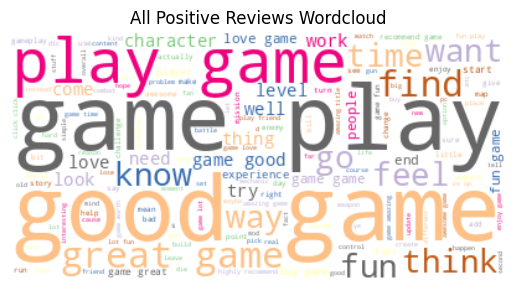

In [13]:
# positive review wordcloud
pos_review = " ".join(rev for rev in positive_data["review_processed"])

wordcloud = WordCloud(background_color="white", colormap="Accent_r").generate(pos_review)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Positive Reviews Wordcloud")
plt.axis("off")
plt.show()

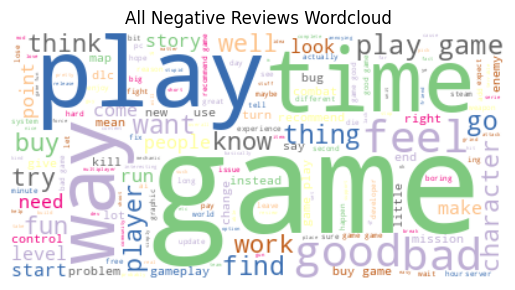

In [14]:
# negative review wordcloud
ne_review = " ".join(rev for rev in negative_data["review_processed"])

wordcloud = WordCloud(background_color="white", colormap="Accent_r").generate(ne_review)

plt.imshow(wordcloud, interpolation='bilinear')
plt.title("All Negative Reviews Wordcloud")
plt.axis("off")
plt.show()

## Statistics: Correlations

In [15]:
# correlation between review_score and review_votes
data[["review_score", "review_votes"]].corr()

,review_score,review_votes
review_score,1.000000,-0.126758
review_votes,-0.126758,1.000000


## Data Processing and Modeling

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgbm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [17]:
# function to show results
def show_metrics(y_test, predictions):
    print("Confusion Matrix: ")
    cmat = metrics.confusion_matrix(y_test, predictions)
    print(cmat)
    print("True Positives (TP) = ", cmat[0,0])
    print("True Negatives (TN) = ", cmat[1,1])
    print("False Positives (FP) = ", cmat[0,1])
    print("False Negatives (FN) = ", cmat[1,0])
    print("Accuracy: ")
    print(metrics.accuracy_score(y_test, predictions))
    print("Precision: ")
    print(metrics.precision_score(y_test, predictions))
    print("F1 Score: ")
    print(metrics.f1_score(y_test, predictions))
    print("Classification Report: ")
    print(metrics.classification_report(y_test, predictions))

In [18]:
X = data["review_processed"]
y = data["review_score"]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [20]:
tfvec = TfidfVectorizer(max_features=2000)
X_train_tfvec = tfvec.fit_transform(X_train)

X_test_tfvec = tfvec.transform(X_test)

# high dimensionality training data makes it hard to run efficiently unless GPU is active
X_train_tfvec.shape

(156361, 2000)

## Logistic Regression

In [21]:
lr = LogisticRegression(max_iter=3000, random_state=42)
lr.fit(X_train_tfvec, y_train)

lr_pred = lr.predict(X_test_tfvec)

print("Logistic Regression: ")
lr_train = lr.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, lr_train))

show_metrics(y_test, lr_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, lr.predict_proba(X_test_tfvec)[:, 1]))

Logistic Regression: 
Training Accuracy:  0.8942703103715121
Confusion Matrix: 
[[ 3251  3327]
 [ 1059 31454]]
True Positives (TP) =  3251
True Negatives (TN) =  31454
False Positives (FP) =  3327
False Negatives (FN) =  1059
Accuracy: 
0.8878002609296257
Precision: 
0.9043443259250741
F1 Score: 
0.9348233126281689
Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.49      0.60      6578
           1       0.90      0.97      0.93     32513

    accuracy                           0.89     39091
   macro avg       0.83      0.73      0.77     39091
weighted avg       0.88      0.89      0.88     39091

ROC AUC Score:  0.9030912110680204


## Decision Tree

In [22]:
dtc_clf = DecisionTreeClassifier(random_state=42)
dtc_clf.fit(X_train_tfvec, y_train)

dtc_pred = dtc_clf.predict(X_test_tfvec)

print("Decision Tree: ")
dtc_train = dtc_clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, dtc_train))

show_metrics(y_test, dtc_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, dtc_clf.predict_proba(X_test_tfvec)[:, 1]))

Decision Tree: 
Training Accuracy:  0.9937964070324442
Confusion Matrix: 
[[ 2841  3737]
 [ 3240 29273]]
True Positives (TP) =  2841
True Negatives (TN) =  29273
False Positives (FP) =  3737
False Negatives (FN) =  3240
Accuracy: 
0.82151901972321
Precision: 
0.8867918812481066
F1 Score: 
0.8935183065488455
Classification Report: 
              precision    recall  f1-score   support

           0       0.47      0.43      0.45      6578
           1       0.89      0.90      0.89     32513

    accuracy                           0.82     39091
   macro avg       0.68      0.67      0.67     39091
weighted avg       0.82      0.82      0.82     39091

ROC AUC Score:  0.666072949167738


## Random Forest

In [23]:
%%time
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_tfvec, y_train)

rf_pred = rf_clf.predict(X_test_tfvec)

print("Random Forest: ")
rf_train = rf_clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, rf_train))

show_metrics(y_test, rf_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, rf_clf.predict_proba(X_test_tfvec)[:, 1]))

Random Forest: 
Training Accuracy:  0.9937900115757766
Confusion Matrix: 
[[ 2220  4358]
 [  732 31781]]
True Positives (TP) =  2220
True Negatives (TN) =  31781
False Positives (FP) =  4358
False Negatives (FN) =  732
Accuracy: 
0.8697910004860454
Precision: 
0.8794100556185838
F1 Score: 
0.9258579502417992
Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.34      0.47      6578
           1       0.88      0.98      0.93     32513

    accuracy                           0.87     39091
   macro avg       0.82      0.66      0.70     39091
weighted avg       0.86      0.87      0.85     39091

ROC AUC Score:  0.8648101439546735
CPU times: user 14min 17s, sys: 340 ms, total: 14min 17s
Wall time: 14min 18s


## XGBoost

In [24]:
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_tfvec, y_train)

xgb_pred = xgb_clf.predict(X_test_tfvec)

print("XGBoost: ")
xgb_train = xgb_clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, xgb_train))

show_metrics(y_test, xgb_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, xgb_clf.predict_proba(X_test_tfvec)[:, 1]))

XGBoost: 
Training Accuracy:  0.8993291165955705
Confusion Matrix: 
[[ 2550  4028]
 [  855 31658]]
True Positives (TP) =  2550
True Negatives (TN) =  31658
False Positives (FP) =  4028
False Negatives (FN) =  855
Accuracy: 
0.8750863370085186
Precision: 
0.8871266042705823
F1 Score: 
0.9284007096878254
Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.39      0.51      6578
           1       0.89      0.97      0.93     32513

    accuracy                           0.88     39091
   macro avg       0.82      0.68      0.72     39091
weighted avg       0.86      0.88      0.86     39091

ROC AUC Score:  0.8814802773607212


## Naive Bayes

In [25]:
clf = MultinomialNB()
clf.fit(X_train_tfvec, y_train)

nb_pred = clf.predict(X_test_tfvec)

print("Naive Bayes: ")
nb_train = clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, nb_train))

show_metrics(y_test, nb_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, clf.predict_proba(X_test_tfvec)[:, 1]))

Naive Bayes: 
Training Accuracy:  0.8623633770569388
Confusion Matrix: 
[[ 1337  5241]
 [  242 32271]]
True Positives (TP) =  1337
True Negatives (TN) =  32271
False Positives (FP) =  5241
False Negatives (FN) =  242
Accuracy: 
0.8597375354941035
Precision: 
0.8602847088931542
F1 Score: 
0.9216993930739023
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.20      0.33      6578
           1       0.86      0.99      0.92     32513

    accuracy                           0.86     39091
   macro avg       0.85      0.60      0.62     39091
weighted avg       0.86      0.86      0.82     39091

ROC AUC Score:  0.8845542237767288


## K Nearest Neighbors

In [26]:
# high dimensionality - takes very long to run 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_tfvec, y_train)

knn_pred = knn.predict(X_test_tfvec)

print("K Nearest Neighbors: ")
knn_train = knn.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, knn_train))

show_metrics(y_test, knn_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, knn.predict_proba(X_test_tfvec)[:, 1]))

K Nearest Neighbors: 
Training Accuracy:  0.9432467175318654
Confusion Matrix: 
[[ 1162  5416]
 [ 1170 31343]]
True Positives (TP) =  1162
True Negatives (TN) =  31343
False Positives (FP) =  5416
False Negatives (FN) =  1170
Accuracy: 
0.8315213220434371
Precision: 
0.8526619331320221
F1 Score: 
0.9049255110289871
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      0.18      0.26      6578
           1       0.85      0.96      0.90     32513

    accuracy                           0.83     39091
   macro avg       0.68      0.57      0.58     39091
weighted avg       0.79      0.83      0.80     39091

ROC AUC Score:  0.6649695665855089


## LightGBM

In [27]:
lgb_clf = lgbm.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train_tfvec, y_train)

lgb_pred = lgb_clf.predict(X_test_tfvec)

print("LightGBM: ")
lgb_train = lgb_clf.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, lgb_train))

show_metrics(y_test, lgb_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, lgb_clf.predict_proba(X_test_tfvec)[:, 1]))

[LightGBM] [Info] Number of positive: 130090, number of negative: 26271
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.704542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390331
[LightGBM] [Info] Number of data points in the train set: 156361, number of used features: 2000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.831985 -> initscore=1.599761
[LightGBM] [Info] Start training from score 1.599761
LightGBM: 
Training Accuracy:  0.8930359872346685
Confusion Matrix: 
[[ 2827  3751]
 [  948 31565]]
True Positives (TP) =  2827
True Negatives (TN) =  31565
False Positives (FP) =  3751
False Negatives (FN) =  948
Accuracy: 
0.8797933028062725
Precision: 
0.8937875184052554
F1 Score: 
0.9307228471597694
Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.43      0.55      6578
           1       0.89      0.97      0.93     32513

    accur

## AdaBoost

In [28]:
ada = AdaBoostClassifier(random_state=42)
ada.fit(X_train_tfvec, y_train)

ada_pred = ada.predict(X_test_tfvec)

print("AdaBoost: ")
ada_train = ada.predict(X_train_tfvec)
print("Training Accuracy: ", metrics.accuracy_score(y_train, ada_train))

show_metrics(y_test, ada_pred)

print("ROC AUC Score: ", roc_auc_score(y_test, ada.predict_proba(X_test_tfvec)[:, 1]))

AdaBoost: 
Training Accuracy:  0.8626767544336503
Confusion Matrix: 
[[ 2003  4575]
 [  928 31585]]
True Positives (TP) =  2003
True Negatives (TN) =  31585
False Positives (FP) =  4575
False Negatives (FN) =  928
Accuracy: 
0.8592259087769564
Precision: 
0.8734789823008849
F1 Score: 
0.9198666142443173
Classification Report: 
              precision    recall  f1-score   support

           0       0.68      0.30      0.42      6578
           1       0.87      0.97      0.92     32513

    accuracy                           0.86     39091
   macro avg       0.78      0.64      0.67     39091
weighted avg       0.84      0.86      0.84     39091

ROC AUC Score:  0.8229199070424453


In [29]:
# use svc as a base learner - this one takes a long time to run!
# svc = SVC(probability=True, kernel="linear", random_state=42)

# ada_svc = AdaBoostClassifier(base_estimator=svc, random_state=42)
# ada_svc.fit(X_train_tfvec, y_train)

# ada_svc_pred = ada_svc.predict(X_test_tfvec)

# show_metrics(y_test, ada_svc_pred)